# A QNN based on Parametric Quantum Circuit for classification of MNIST images
## Tutorial - Hands-on ##

**Version:** V2.0 <p>
**Authors:** Stefano Giagu <stefano.giagu@uniroma1.it>


**Scope:**: learn how to design a simple variational PQC and train it for a multiclass classification task using the [pennylane](https://pennylane.ai/) platform with [pytorch](https://pytorch.org/) backend

**Libraries:** numpy, matplotlib, pennylane, torch

In [1]:
# only needed on google colab
#!pip install pennylane-lightning-gpu

In [2]:
# import needed libraries
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
os.environ["WORLD_SIZE"] = "1"

from time import time
from tqdm import tqdm

import torch
import pennylane as qml
print('Torch version: ', torch.__version__)
print('Pennylane version: ', qml.__version__)

Torch version:  2.3.1+cu121
Pennylane version:  0.36.0


In [3]:
# check if GPU is available
# Note: the example can also be run on CPU w/o problems

if torch.cuda.is_available():
  print('Number of available GPUs: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))
  !nvidia-smi
else:
  print('No GPU available')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Number of available GPUs:  1
NVIDIA A100 80GB PCIe MIG 1g.10gb
Wed Nov 20 17:04:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          On  |   00000000:00:05.0 Off |                   On |
| N/A   39C    P0             74W /  300W |                  N/A   |     N/A      Default |
|                                         |                        |         

In [4]:
# check Pennylane software stack
qml.about()

Name: PennyLane
Version: 0.36.0
Summary: PennyLane is a cross-platform Python library for quantum computing, quantum machine learning, and quantum chemistry. Train a quantum computer the same way as a neural network.
Home-page: https://github.com/PennyLaneAI/pennylane
Author: 
Author-email: 
License: Apache License 2.0
Location: /envs/qml/lib/python3.11/site-packages
Requires: appdirs, autograd, autoray, cachetools, networkx, numpy, pennylane-lightning, requests, rustworkx, scipy, semantic-version, toml, typing-extensions
Required-by: PennyLane-Cirq, PennyLane-qiskit, PennyLane_Lightning, PennyLane_Lightning_GPU

Platform info:           Linux-5.15.0-125-generic-x86_64-with-glibc2.35
Python version:          3.11.9
Numpy version:           1.26.4
Scipy version:           1.13.1
Installed devices:
- default.clifford (PennyLane-0.36.0)
- default.gaussian (PennyLane-0.36.0)
- default.mixed (PennyLane-0.36.0)
- default.qubit (PennyLane-0.36.0)
- default.qubit.autograd (PennyLane-0.36.0)
- 

In [5]:
# Download MNIST dataset (from torchvision repository)

import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Download MNIST and prepare transforms
# we donwsample MNIST images from 28x28 to 16x16 pixels in order to reduce the number of qubit needed to represent each image
mnist_train = datasets.MNIST(root='./data', train=True, download=True,
                             transform=transforms.Compose([
                                transforms.Resize((16, 16)),                # Resize to 16x16
                                transforms.ToTensor(),                      # Convert to torch tensors
                                transforms.Normalize((0.1307,), (0.3081,))  # Normalize
                             ]))


# Filter for 0,1,2,3 digits (in the example we train the QNN for a multiclass classification task, classification of 0,1,2 and 3 digits)
data = []
targets = []
for image, label in mnist_train:
    if label in [0, 1, 2, 3]:
        data.append(image.squeeze())
        targets.append(label)

data = torch.stack(data)
targets = torch.tensor(targets)

# Select 0,1,2,3 to implement a simpler multiclass classification problem
zeros_indices = (targets == 0)
ones_indices = (targets == 1)
twos_indices = (targets == 2)
threes_indices = (targets == 3)

zeros = data[zeros_indices]
ones = data[ones_indices]
twos = data[twos_indices]
threes = data[threes_indices]

# take a subsample of the dataset to imit the training time: 1024 0,1,2, and 3s for training and an equal size set for test
zeros_train = zeros[:1024]
ones_train = ones[:1024]
twos_train = twos[:1024]
threes_train = threes[:1024]

zeros_test = zeros[1024:2048]
ones_test = ones[1024:2048]
twos_test = twos[1024:2048]
threes_test = threes[1024:2048]

In [6]:
# normalize images in [0,1]

def normalize(imgs):
  maxes, _ = torch.max(imgs.reshape(-1, 16*16), dim = 1)
  mins, _ = torch.min(imgs.reshape(-1, 16*16), dim = 1)

  mins = mins.unsqueeze(1).unsqueeze(2)
  maxes = maxes.unsqueeze(1).unsqueeze(2)

  return (imgs-mins)/(maxes-mins)

zeros_train = normalize(zeros_train)
ones_train = normalize(ones_train)
twos_train = normalize(twos_train)
threes_train = normalize(threes_train)

zeros_test = normalize(zeros_test)
ones_test = normalize(ones_test)
twos_test = normalize(twos_test)
threes_testn = normalize(threes_test)

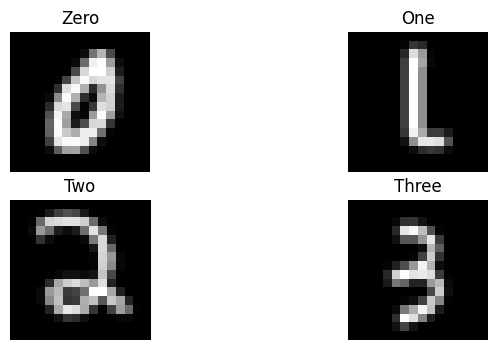

In [7]:
# plot two examples of the input images

# Select a random sample index
zero_idx = np.random.randint(0, zeros_train.shape[0])
one_idx = np.random.randint(0, ones_train.shape[0])

# Extract the images
sample_zero = zeros_train[zero_idx]
sample_one = ones_train[one_idx]
sample_twos = twos_train[zero_idx]
sample_threes = threes_train[one_idx]

# Plot the images
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 4))

ax1.imshow(sample_zero, cmap='gray')
ax1.set_title('Zero')
ax1.axis('off')

ax2.imshow(sample_one, cmap='gray')
ax2.set_title('One')
ax2.axis('off')

ax3.imshow(sample_twos, cmap='gray')
ax3.set_title('Two')
ax3.axis('off')

ax4.imshow(sample_threes, cmap='gray')
ax4.set_title('Three')
ax4.axis('off')

plt.show()

In [8]:
# assert images have min 0 and max 1 within an error of 1e-5
assert torch.allclose(zeros_train.min(), torch.tensor(0., dtype = torch.float32), atol=1e-5)
assert torch.allclose(zeros_train.max(), torch.tensor(1., dtype = torch.float32), atol=1e-5)
assert torch.allclose(ones_train.min(), torch.tensor(0., dtype = torch.float32), atol=1e-5)
assert torch.allclose(ones_train.max(), torch.tensor(1., dtype = torch.float32), atol=1e-5)

assert torch.allclose(zeros_test.min(), torch.tensor(0., dtype = torch.float32), atol=1e-5)
assert torch.allclose(zeros_test.max(), torch.tensor(1., dtype = torch.float32), atol=1e-5)
assert torch.allclose(ones_test.min(), torch.tensor(0., dtype = torch.float32), atol=1e-5)
assert torch.allclose(ones_test.max(), torch.tensor(1., dtype = torch.float32), atol=1e-5)

# concatenate the 0,1,2, and 3 datasets in just one training dataset
zeros_train = zeros_train.flatten(start_dim = 1)
ones_train = ones_train.flatten(start_dim = 1)
twos_train = twos_train.flatten(start_dim = 1)
threes_train = threes_train.flatten(start_dim = 1)
dataset_train = torch.cat((zeros_train, ones_train, twos_train, threes_train), dim = 0)

# same for test
zeros_test = zeros_test.flatten(start_dim = 1)
ones_test = ones_test.flatten(start_dim = 1)
twos_test = twos_test.flatten(start_dim = 1)
threes_test = threes_test.flatten(start_dim = 1)
dataset_test = torch.cat((zeros_test, ones_test, twos_test, threes_test), dim = 0)

# add labels
labels_train = torch.cat(
    (torch.zeros((zeros_train.shape[0], 1), dtype=torch.long),
     torch.ones((ones_train.shape[0], 1), dtype=torch.long),
     torch.full((twos_train.shape[0], 1), 2, dtype=torch.long),
     torch.full((threes_train.shape[0], 1),3, dtype=torch.long)),
     dim = 0).squeeze()
labels_test = torch.cat((torch.zeros((zeros_test.shape[0], 1), dtype=torch.long), torch.ones((ones_test.shape[0], 1), dtype=torch.long), torch.full((twos_test.shape[0], 1), 2, dtype=torch.long), torch.full((threes_test.shape[0], 1), 3, dtype=torch.long)), dim = 0).squeeze()


In [9]:
# build torch datasets and dataloaders
BATCH_SIZE = 32

# build dataset
dataset_train = torch.utils.data.TensorDataset(dataset_train, labels_train)
dataset_test = torch.utils.data.TensorDataset(dataset_test, labels_test)

#build dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

In [10]:
# Define a quantum device (eg the number of qubits in the circuit)

NUM_QUBITS = 8 # we need 8 qubits to encode 16x16 features
NUM_LAYERS = 3 #n umber of layers in the QNN (each layer is composed by a parametric unitary transformation given by 3 rotation and CNOT gates to entangle qubits)

# definition of the quantum parametric circuit
# the circuit ansatz is made by NUM_LAYERS of the same unitary block made of a 3 parametric rotations gates(along X, Y and Z) in the block sphere for each qubit, folloeed by a ladder of CNOT
# gates to entangle the qubits

dev = qml.device("default.qubit", wires=NUM_QUBITS) #"default.qubit" is the default pennylane differentiable quantum device simulator that is capable of backprop derivatives

@qml.qnode(dev, interface="torch")
def circuit_block(params, state=None):

    # Load the initial state if provided
    # quantum encoding (using amplitude encoding: Encodes 2𝑛 features into the amplitude vector of 𝑛 qubits), to represent a valid quantum state vector, the L2-norm of features must be one, this can be achieved
    # either by manually normalizing the data (ex: state = state / torch.linalg.norm(state, dim=1).view(-1, 1)), or automatically by setting the argument normalize=True
    if state is not None: qml.AmplitudeEmbedding(features=state, wires=range(NUM_QUBITS), normalize=True)

    # Alternatively as we are in simulation also a simplified encoding as normalized state vector can be used (ok in simulation, allows to skip quantum encoding of the classical
    # data, requires the input to be pre-normalized as a quantum state (eg L2 norm = 1.0: state = state / torch.linalg.norm(state, dim=1).view(-1, 1)))
    # if state is not None: qml.QubitStateVector(state, wires=range(NUM_QUBITS))

    # Quantum circuit
    for i in range(NUM_LAYERS):

      # Rotation layer
      for j in range(NUM_QUBITS):
          qml.RX(params[i, j, 0], wires=j)   #params is the vector containing the PQC paraneters: size = (NUM_LAYERS, NUM_QUBITS, NUM_ROTATIONS) --> ex. in our case: 3*8*3=72 parameters
          qml.RY(params[i, j, 1], wires=j)
          qml.RZ(params[i, j, 2], wires=j)

      # Entangling layer (a ladder of CNOT gates)
      for j in range(NUM_QUBITS):
          qml.CNOT(wires=[j, (j + 1) % NUM_QUBITS]) # note: when j=NUM_QUBITS-1 ->  (j+1)%NUM_QUBITS = 0


    # Return the probability of measuring one of the base vectors in the first and second qubits
    return qml.probs(wires=[0,1])

  # define general circuit
def circuit(params, state):

    # apply quantum circuit
    basis_state_proba = circuit_block(params, state)

    # return probability of measuring |00> |10> |01> |11> in the first two qubits
    return basis_state_proba

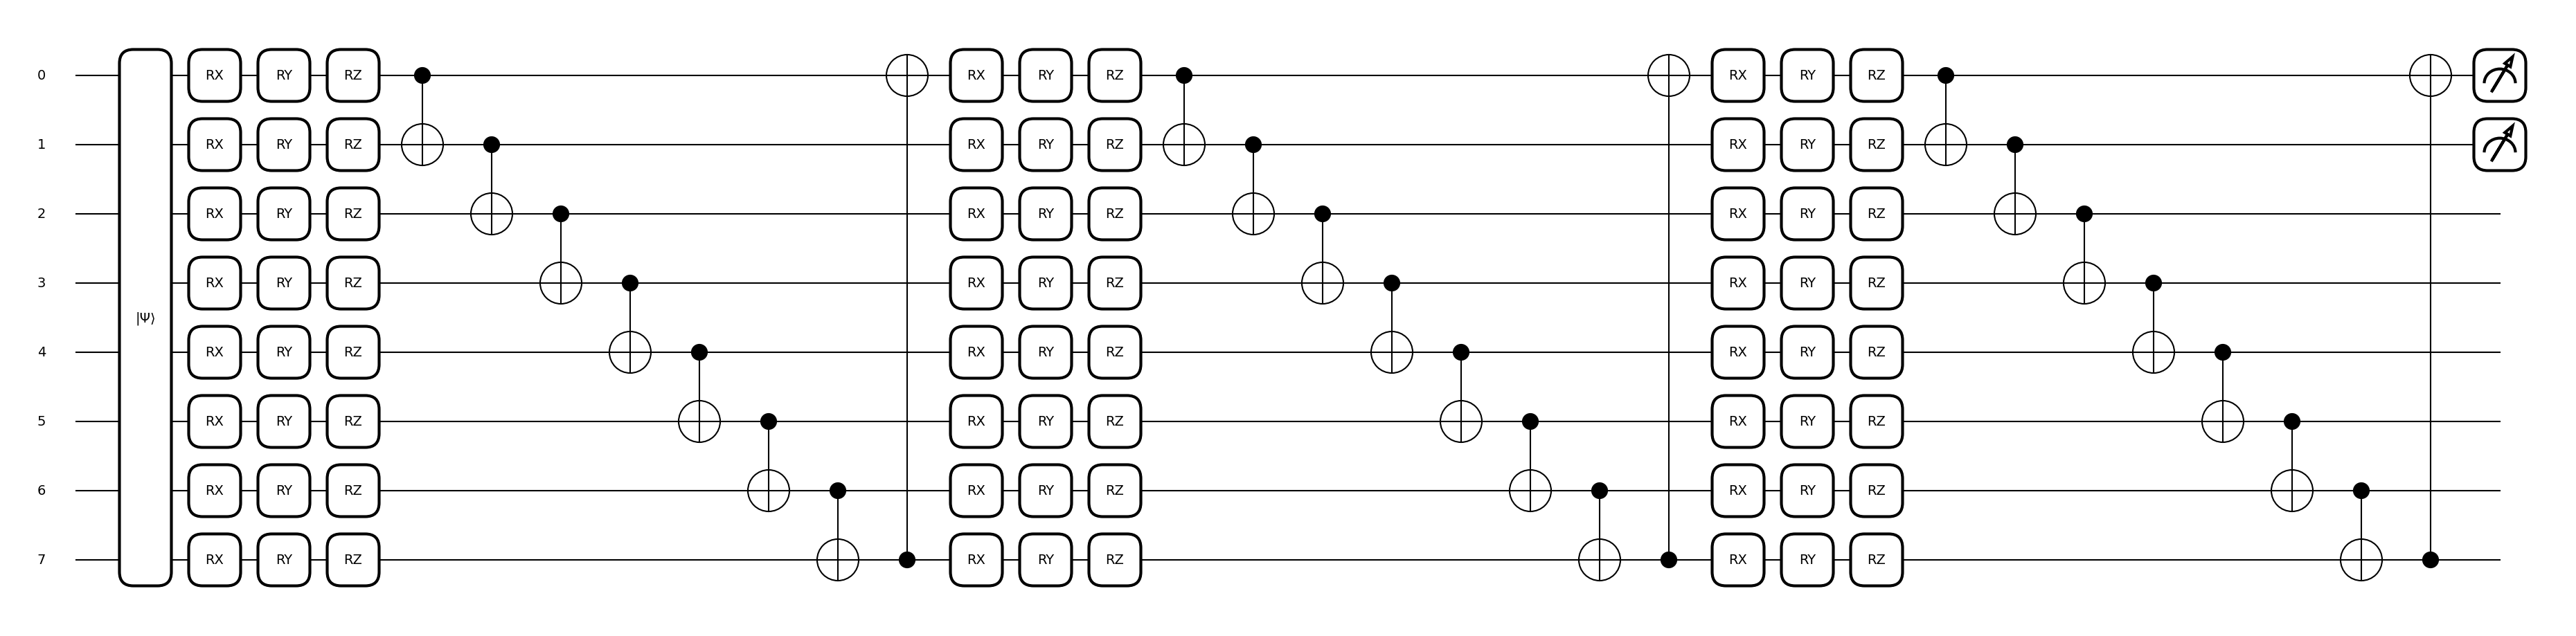

In [11]:
# visualize the qnn
from torch.autograd import Variable

parameters = Variable(torch.normal( mean=0. , std=0.1, size=(NUM_LAYERS, NUM_QUBITS, 3)), requires_grad=True)

state,_ = next(iter(dataloader_train))
#state = state / torch.linalg.norm(state, dim=1).view(-1, 1) #needed in case the qml.QubitStateVector encoding is used

qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(circuit_block)(parameters, state)
plt.show()

In [12]:
def run_exp(batch_size, num_epochs, dataloader, loss_fn):

    loss_history = []
    accuracy_history = []

    avg_time_per_epoch = 0

    # training loop for classification
    for epoch in range(num_epochs):

        t0 = time()

        t_accuracy = 0.0

        # Initialize tqdm progress bar with description showing the current epoch
        with tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}") as tqdm_epoch:
            for _, (data, labels) in tqdm_epoch:

                #needed in case the qml.QubitStateVector encoding is used
                #data = data / torch.linalg.norm(data, dim=1).view(-1, 1)

                # zero the parameter gradients
                optimizer.zero_grad()

                data = data.type(torch.float).to(device=device)
                labels = labels.type(torch.int64).to(device=device)

                # forward pass
                output = circuit(params, data).to(device=device)

                # compute the loss
                loss = loss_fn(output, labels)

                # backward pass
                loss.backward()

                # update the parameters
                optimizer.step()

                # multiclass accuracy
                pred_class = torch.argmax(output, 1)
                acc_tmp = (torch.sum(pred_class == labels).float() / labels.nelement())

                # Optionally, update tqdm bar with batch loss
                tqdm_epoch.set_postfix(loss=loss.item(), accuracy=acc_tmp.item())

        t_accuracy += acc_tmp.item()

        avg_time_per_epoch += time()-t0

        loss_history.append(loss.item())
        accuracy_history.append(t_accuracy)

        # print the time
        print("Time per epoch: ", time()-t0)

        # print the loss
        print("Epoch: ", epoch, "Loss: ", loss.item())

        # print the accuracy
        print("Accuracy: ", t_accuracy)


        print("--------------------------------------------------------------------------")

    return avg_time_per_epoch/NUM_EPOCHS, loss_history, accuracy_history

In [13]:
def run_test(batch_size, dataloader, loss_fn):

    t_loss = 0.0
    t_accuracy = 0.0

    counter = 0
    for data, labels in dataloader:

        counter += 1
        # normalize
        #data = data / torch.linalg.norm(data, dim=1).view(-1, 1)

        data = data.type(torch.float).to(device=device)
        labels = labels.type(torch.int64).to(device=device)

        # forward pass
        output = circuit(params, data)

        # compute the loss
        loss = loss_fn(output, labels)

        # Multiclass accuracy
        pred_class = torch.argmax(output, 1)
        accuracy = (torch.sum(pred_class == labels).float() / labels.nelement())

        t_loss += loss.item()
        t_accuracy += accuracy.item()

    print("Test loss: ", t_loss/counter)
    print("Test accuracy: ", t_accuracy/counter)

    return

In [14]:
# parametres
NUM_EPOCHS = 2
LEARNING_RATE = 1e-3

# define the cost function (Negative LogLikhelihood loss)
loss_fn = torch.nn.NLLLoss()

# initialize parameters randomly
params = torch.randn((NUM_LAYERS, NUM_QUBITS, 3), requires_grad=True)

# define the optimizer
optimizer = torch.optim.Adam([params], lr=LEARNING_RATE)

# training
print(f'\nRunning experiment with batch size {BATCH_SIZE} and layers {NUM_LAYERS}\n')

time_per_epoch, loss_history, accuracy_history = run_exp(BATCH_SIZE, NUM_EPOCHS, dataloader_train, loss_fn)

print(f'Average time per epoch: {time_per_epoch} - BS: {BATCH_SIZE} - LAYERS: {NUM_LAYERS}\n')
print('='*50)


Running experiment with batch size 32 and layers 3



Epoch 1/2: 100%|██████████| 128/128 [00:09<00:00, 14.09it/s, accuracy=0.406, loss=-0.269]


Time per epoch:  9.090920209884644
Epoch:  0 Loss:  -0.26867160201072693
Accuracy:  0.40625
--------------------------------------------------------------------------


Epoch 2/2: 100%|██████████| 128/128 [00:08<00:00, 15.12it/s, accuracy=0.594, loss=-0.277]

Time per epoch:  8.467278718948364
Epoch:  1 Loss:  -0.2767876088619232
Accuracy:  0.59375
--------------------------------------------------------------------------
Average time per epoch: 8.779084324836731 - BS: 32 - LAYERS: 3



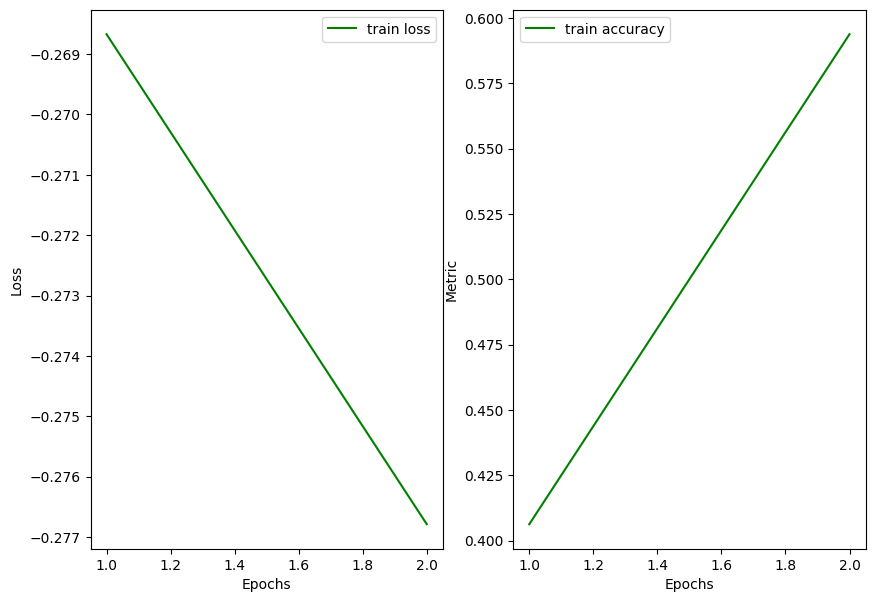

In [15]:
# grafico monitoring training
plt.figure(figsize=(10, 7))
plt.subplot(1,2,1)
plt.plot(range(1,len(loss_history)+1), loss_history, color='green', linestyle='-', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,len(accuracy_history)+1),accuracy_history, color='green', linestyle='-', label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.show()

In [16]:
# test performance

run_test(BATCH_SIZE, dataloader_test, loss_fn)

Test loss:  -0.2876591619569808
Test accuracy:  0.61572265625
